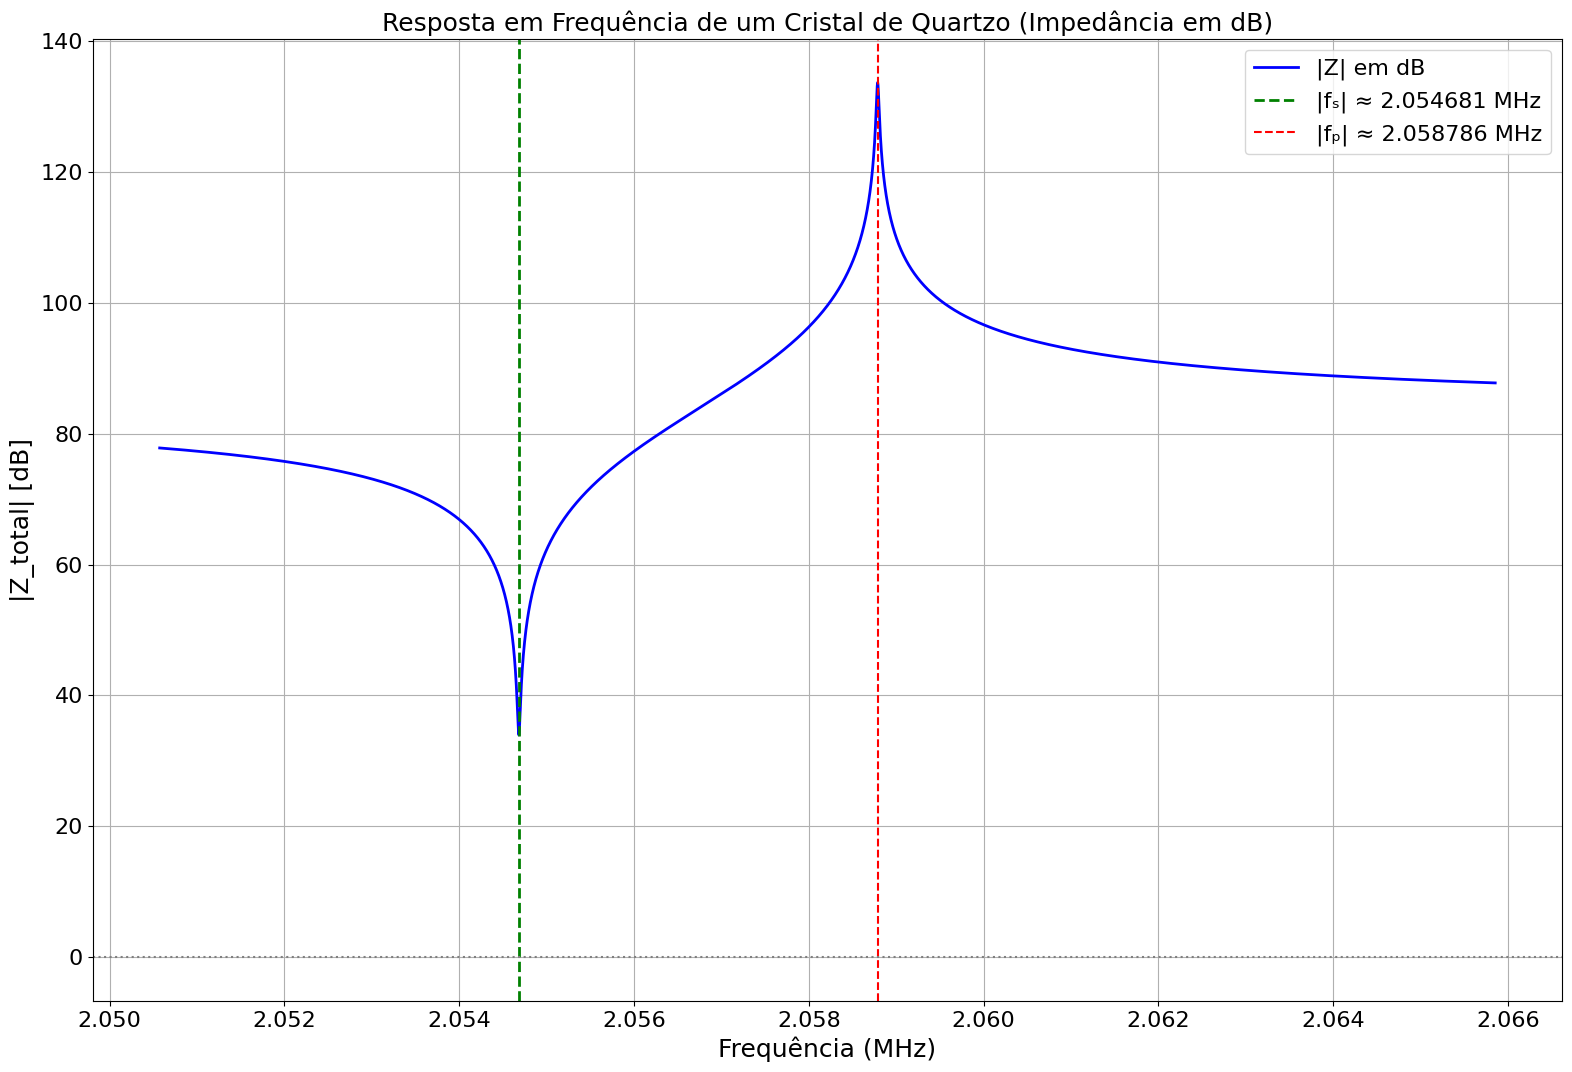

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots


plt.rc('font', size=16)          # tamanho da fonte geral (eixos, ticks)
plt.rc('axes', titlesize=18)     # tamanho da fonte do título dos eixos
plt.rc('axes', labelsize=18)     # tamanho da fonte dos rótulos dos eixos (xlabel, ylabel)
plt.rc('xtick', labelsize=16)    # tamanho da fonte dos ticks no eixo x
plt.rc('ytick', labelsize=16)    # tamanho da fonte dos ticks no eixo y
plt.rc('legend', fontsize=16)    # tamanho da fonte das legendas (se houver)
plt.rc('figure', titlesize=18)   # tamanho da fonte do título da figura (plt.suptitle)

# Parâmetros do cristal
R1 = 50               # Ohms
L1 = 0.3              # Henry
C1 = 0.02e-12         # Farads
C0 = 5e-12            # Farads
CL = 18e-12           # Farads

# Frequência de ressonância teórica
fs = 1 / (2 * np.pi * np.sqrt(L1 * C1))
fp = fs * (1 + C1 / (2 * (C0 + CL)))

# Faixa de frequência
f_start = min(fs, fp) * 0.998
f_stop = max(fs, fp) * 1.005
f = np.linspace(f_start, f_stop, 10000)
w = 2 * np.pi * f

# Impedância motional
Z_m = R1 + 1j * (w * L1 - 1 / (w * C1))

# Impedância total com C0 em paralelo
Z_total = 1 / (1 / Z_m + 1j * w * C0)

# Magnitude da impedância total
Z_abs = np.abs(Z_total)
Z_db = 20 * np.log10(Z_abs + 1e-12)  # em dB

# Localizar os mínimos e máximos da curva
from scipy.signal import find_peaks

inv = -Z_abs
pico_idx, _ = find_peaks(inv)
vale_idx, _ = find_peaks(Z_abs)

fs_real = f[pico_idx[np.argmin(Z_abs[pico_idx])]] if len(pico_idx) > 0 else fs
fp_real = f[vale_idx[np.argmax(Z_abs[vale_idx])]] if len(vale_idx) > 0 else fp

# Plot
plt.figure(figsize=(16, 11))
plt.plot(f / 1e6, Z_db, label="|Z| em dB", color='blue', linewidth=2)
plt.axvline(abs(fs_real) / 1e6, color='green', linestyle='--', label=f"|fₛ| ≈ {fs_real/1e6:.6f} MHz", linewidth=2)
plt.axvline(abs(fp_real) / 1e6, color='red', linestyle='--', label=f"|fₚ| ≈ {fp_real/1e6:.6f} MHz")
plt.axhline(0, color='gray', linestyle=':')

plt.title("Resposta em Frequência de um Cristal de Quartzo (Impedância em dB)")
plt.xlabel("Frequência (MHz)")
plt.ylabel("|Z_total| [dB]")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


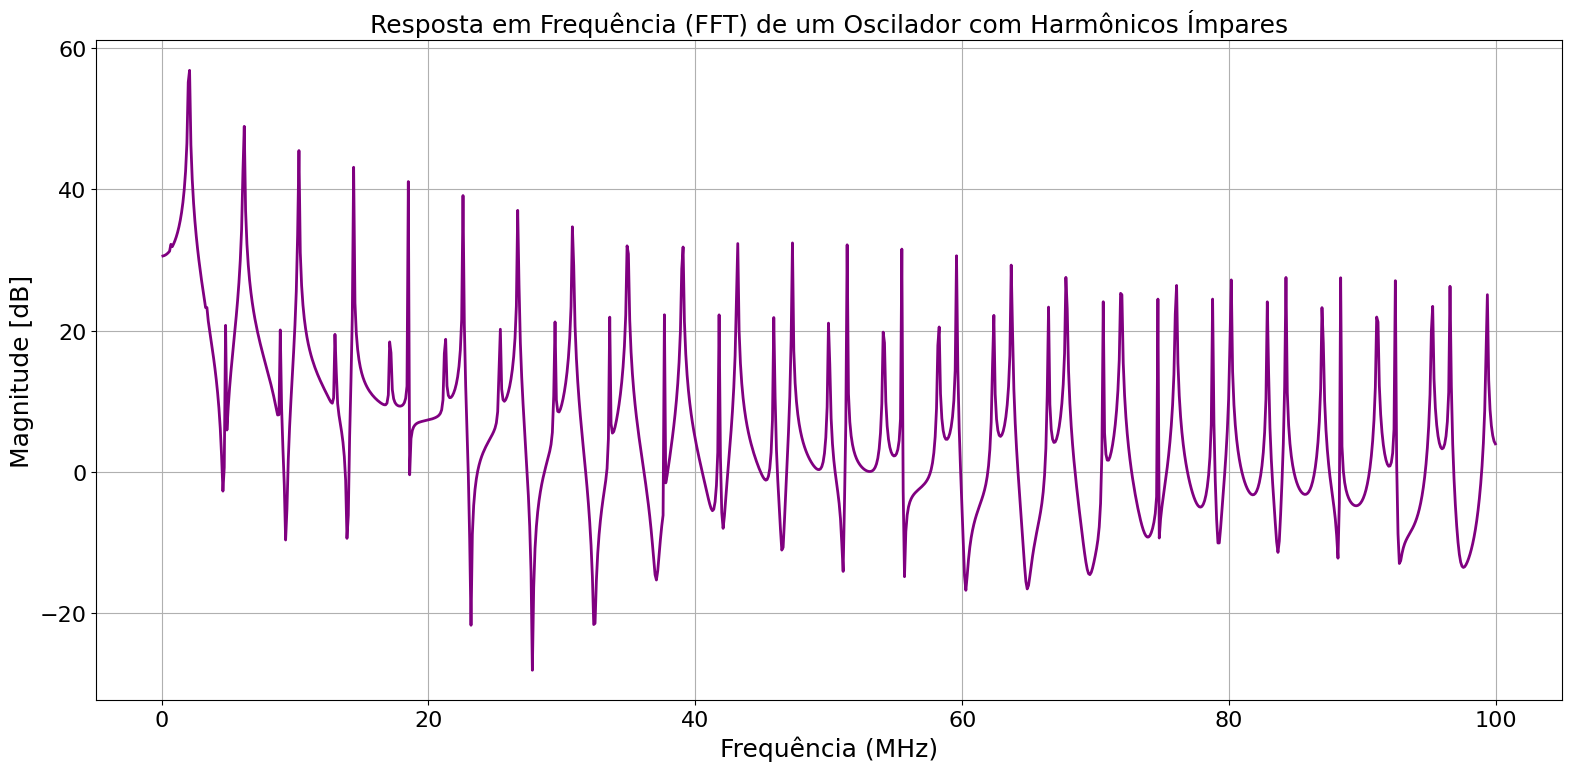

In [36]:
# Sinal oscilador com frequência fundamental e overtones ímpares
f0 = fs_real  # frequência fundamental detectada anteriormente
harmonics = 100  # número de harmônicos ímpares a considerar

# Parâmetros do sinal
duration = 10e-6  # duração do sinal no tempo (em segundos)
sampling_rate = 200e6  # taxa de amostragem (200 MHz)
t = np.arange(0, duration, 1 / sampling_rate)

# Construir sinal com a fundamental e os harmônicos ímpares
signal = np.zeros_like(t)
for n in range(1, harmonics + 1, 2):  # apenas harmônicos ímpares
    signal += np.sin(2 * np.pi * f0 * n * t) / n  # n normaliza a amplitude

# FFT
fft_data = np.fft.fft(signal)
fft_freq = np.fft.fftfreq(len(t), d=1/sampling_rate)
fft_magnitude = np.abs(fft_data)
fft_db = 20 * np.log10(fft_magnitude + 1e-12)

# Plot FFT (apenas parte positiva do espectro)
positive_freqs = fft_freq > 0
plt.figure(figsize=(16, 8))
plt.plot(fft_freq[positive_freqs] / 1e6, fft_db[positive_freqs], color='purple', linewidth=2)
plt.title("Resposta em Frequência (FFT) de um Oscilador com Harmônicos Ímpares")
plt.xlabel("Frequência (MHz)")
plt.ylabel("Magnitude [dB]")
plt.grid(True)
plt.tight_layout()
plt.show()


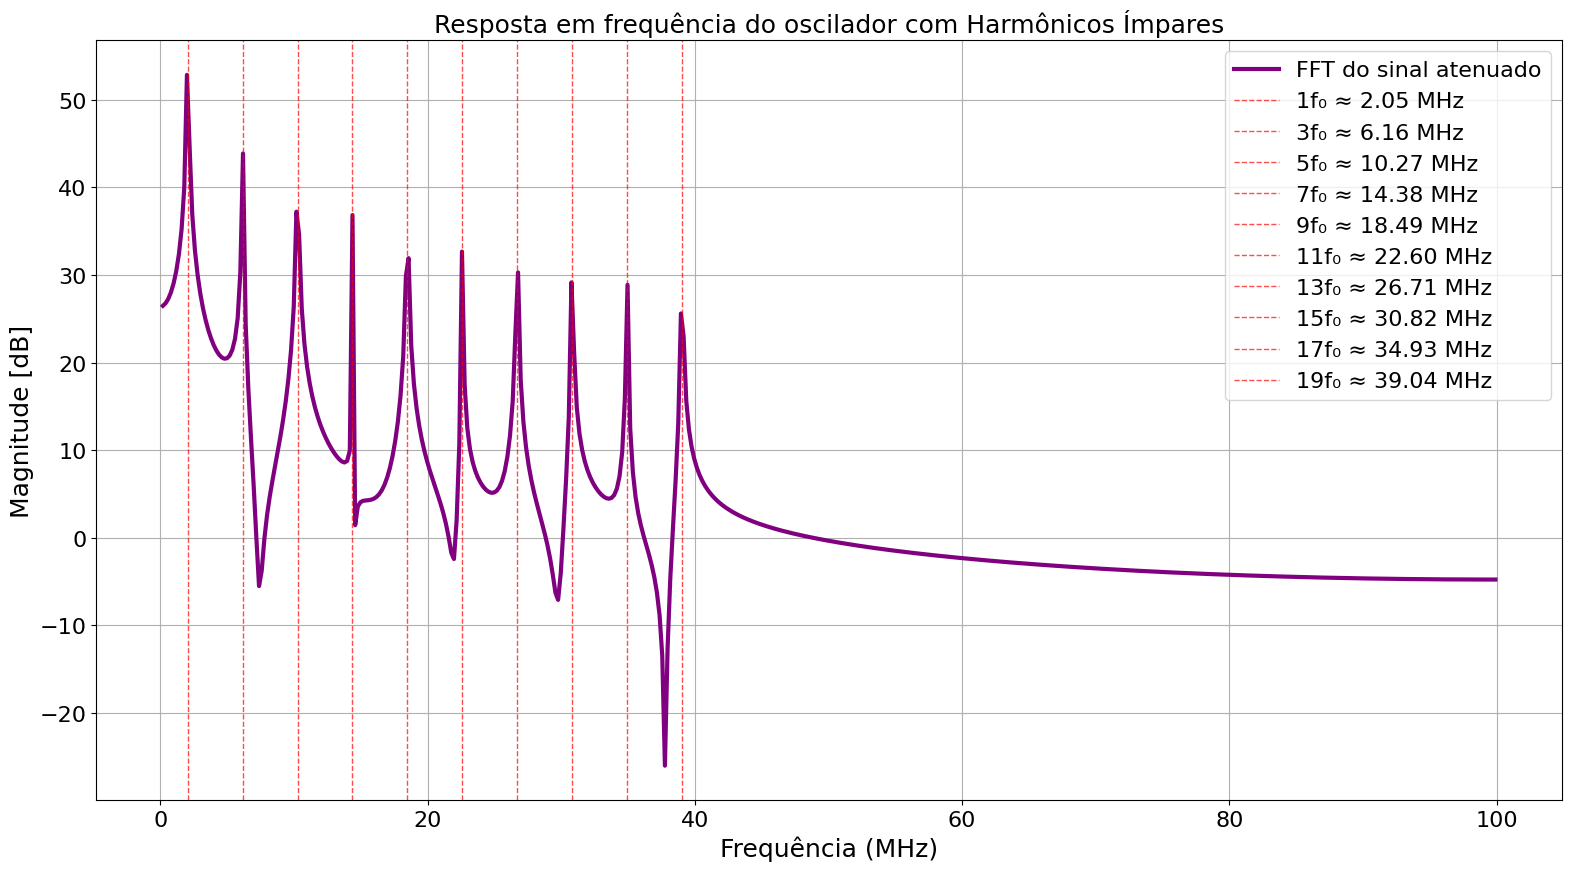

In [37]:
# Frequência fundamental detectada anteriormente
f0 = fs_real
harmonics = 20  # número de harmônicos ímpares

# Tempo e taxa de amostragem
duration = 5e-6
sampling_rate = 200e6
t = np.arange(0, duration, 1 / sampling_rate)

# Envelope exponencial para simular amortecimento (usando alpha real do cristal)
Q_static = (1 / R1) * np.sqrt(L1 / C1)
alpha = np.pi * f0 / Q_static
envelope = np.exp(-alpha * t)

# Construir sinal com harmônicos ímpares atenuados no tempo
signal = np.zeros_like(t)
for n in range(1, harmonics + 1, 2):
    signal += (np.sin(2 * np.pi * f0 * n * t) / n)  # ainda normaliza por n
signal *= envelope  # aplica o decaimento exponencial

# FFT
fft_data = np.fft.fft(signal)
fft_freq = np.fft.fftfreq(len(t), d=1/sampling_rate)
fft_magnitude = np.abs(fft_data)
fft_db = 20 * np.log10(fft_magnitude + 1e-12)

# Plot (parte positiva)
positive_freqs = fft_freq > 0
plt.figure(figsize=(16, 9))
plt.plot(fft_freq[positive_freqs] / 1e6, fft_db[positive_freqs], color='purple', linewidth=3, label='FFT do sinal atenuado')

# Barras verticais com legenda apenas uma vez por harmônico
for n in range(1, harmonics + 1, 2):
    freq_n = f0 * n
    plt.axvline(freq_n / 1e6, linestyle='--', linewidth=1, color='red', alpha=0.7,
                label=f'{n}f₀ ≈ {freq_n/1e6:.2f} MHz')

# Para evitar repetição de legendas
handles, labels = plt.gca().get_legend_handles_labels()
unique = dict(zip(labels, handles))
plt.legend(unique.values(), unique.keys())

plt.title("Resposta em frequência do oscilador com Harmônicos Ímpares")
plt.xlabel("Frequência (MHz)")
plt.ylabel("Magnitude [dB]")
plt.grid(True)
plt.tight_layout()
plt.show()


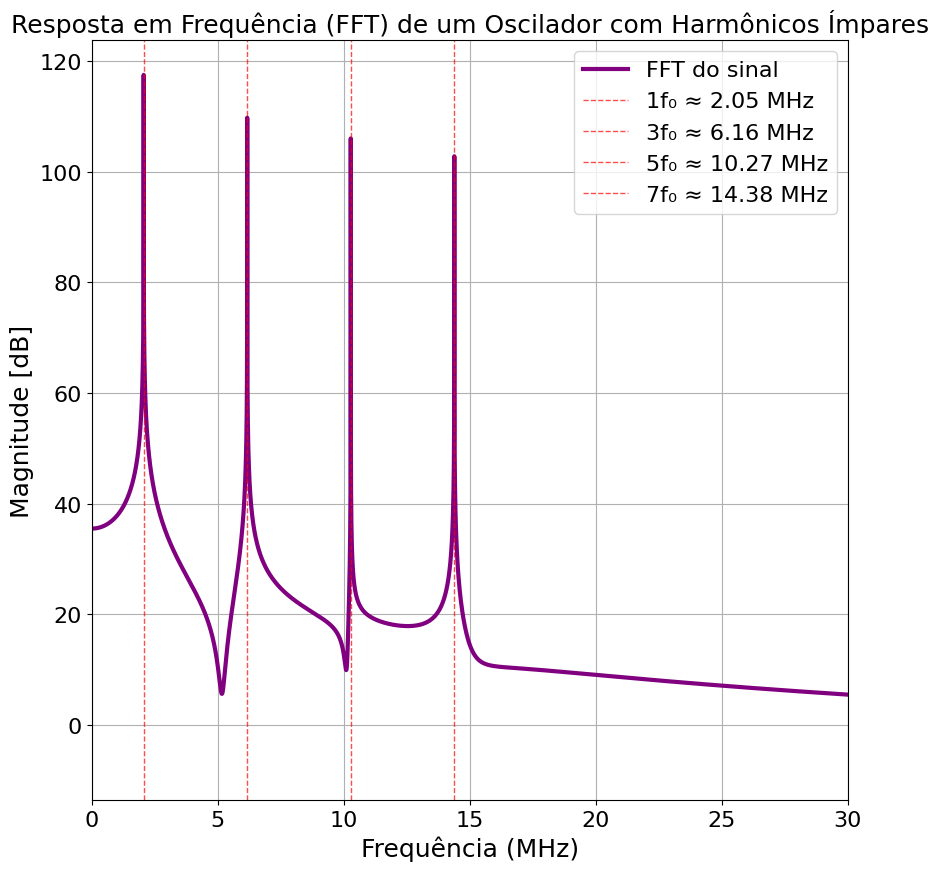

In [38]:
# Sinal oscilador com frequência fundamental e overtones ímpares
f0 = fs_real  # frequência fundamental detectada anteriormente
harmonics = 7  # número de harmônicos ímpares a considerar

# Parâmetros do sinal
duration = 5e-3  # duração do sinal no tempo (em segundos)
sampling_rate = 400e6  # taxa de amostragem (200 MHz)
t = np.arange(0, duration, 1 / sampling_rate)

# Construir sinal com a fundamental e os harmônicos ímpares
signal = np.zeros_like(t)
for n in range(1, harmonics + 1, 2):  # apenas harmônicos ímpares
    signal += np.sin(2 * np.pi * f0 * n * t) / n  # n normaliza a amplitude

# FFT
fft_data = np.fft.fft(signal)
fft_freq = np.fft.fftfreq(len(t), d=1/sampling_rate)
fft_magnitude = np.abs(fft_data)
fft_db = 20 * np.log10(fft_magnitude + 1e-12)

# Plot FFT (apenas parte positiva do espectro)
positive_freqs = fft_freq > 0
plt.figure(figsize=(9, 9))
plt.plot(fft_freq[positive_freqs] / 1e6, fft_db[positive_freqs], color='purple', linewidth=3, label='FFT do sinal')

# Barras verticais com legenda para cada harmônico ímpar
for n in range(1, harmonics + 1, 2):
    freq_n = f0 * n
    plt.axvline(freq_n / 1e6, linestyle='--', linewidth=1, color='red', alpha=0.7,
                label=f'{n}f₀ ≈ {freq_n/1e6:.2f} MHz')

plt.title("Resposta em Frequência (FFT) de um Oscilador com Harmônicos Ímpares")
plt.xlabel("Frequência (MHz)")
plt.ylabel("Magnitude [dB]")
plt.xlim(0, 30)  # Limitar o eixo x para melhor visualização
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


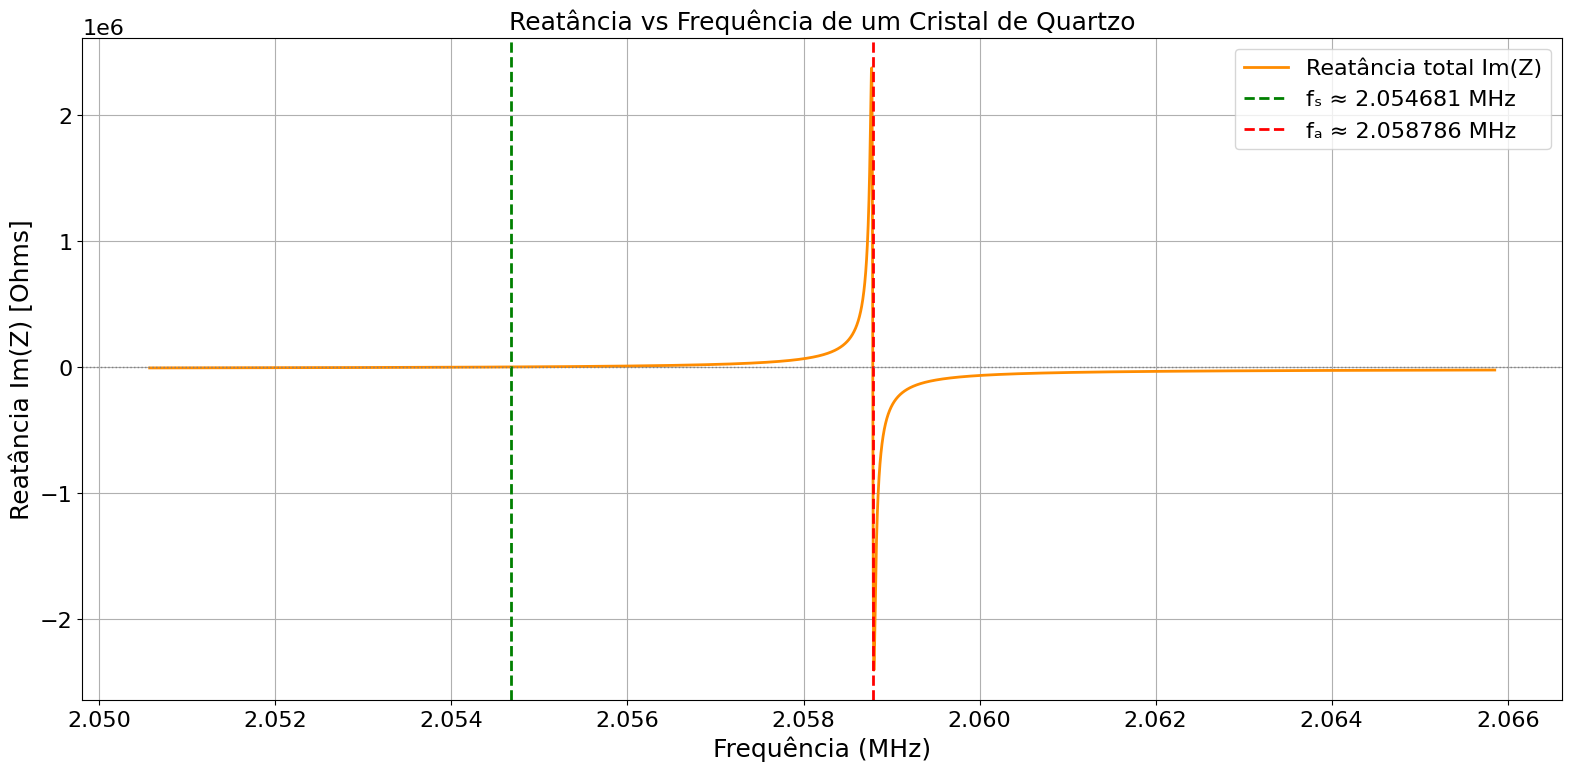

In [39]:
# Cálculo da reatância (parte imaginária da impedância total)
X_total = np.imag(Z_total)

# Plot da reatância
plt.figure(figsize=(16, 8))
plt.plot(f / 1e6, X_total, color='darkorange', linewidth=2, label='Reatância total Im(Z)')

# Linhas verticais para fs e fa
plt.axvline(fs_real / 1e6, linestyle='--', color='green', linewidth=2, label=f'fₛ ≈ {fs_real/1e6:.6f} MHz')
plt.axvline(fp_real / 1e6, linestyle='--', color='red', linewidth=2, label=f'fₐ ≈ {fp_real/1e6:.6f} MHz')

# Eixos e grid
plt.axhline(0, color='gray', linestyle=':', linewidth=1)
plt.title("Reatância vs Frequência de um Cristal de Quartzo")
plt.xlabel("Frequência (MHz)")
plt.ylabel("Reatância Im(Z) [Ohms]")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Fator Q (teórico): 77459.67


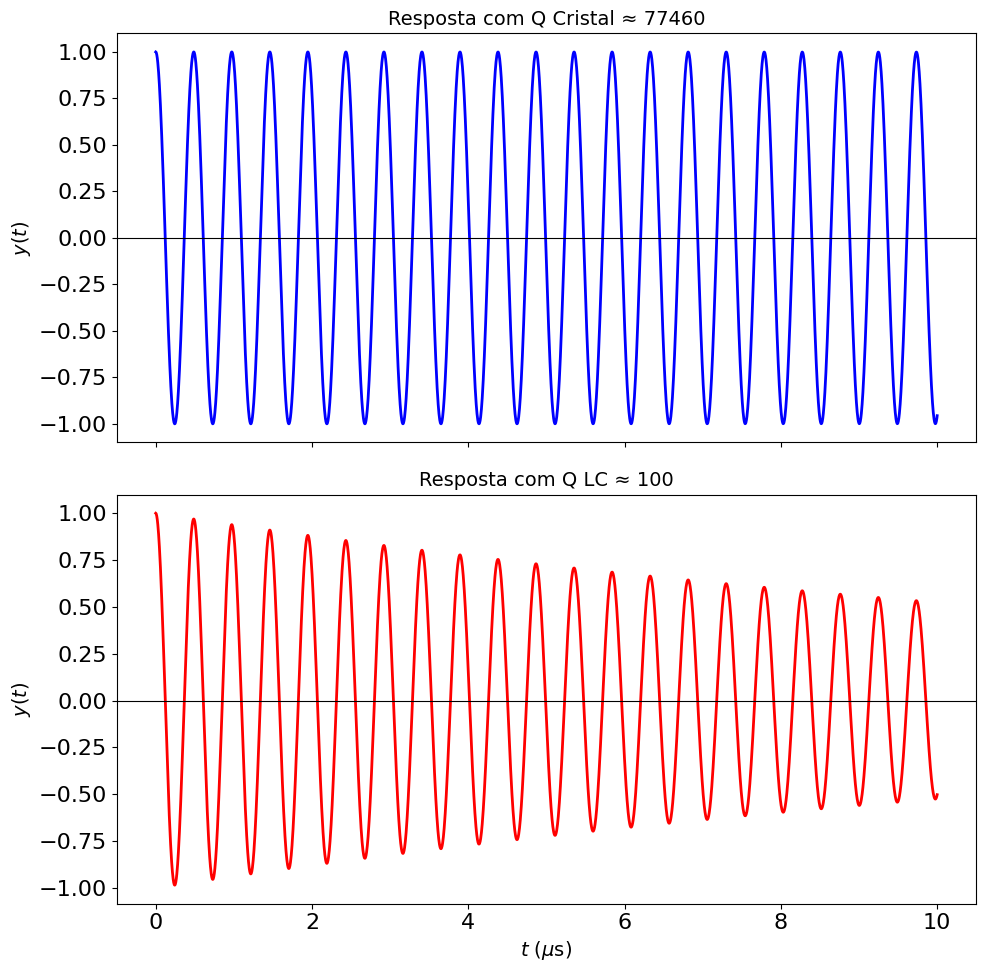

In [40]:
# Valor de Q teórico (motional branch)
Q_static = (1 / R1) * np.sqrt(L1 / C1)
print(f"Fator Q (teórico): {Q_static:.2f}")

# Tempo mais longo para observar amortecimento
t = np.linspace(0, 10e-6, 3000)  # 0 a 500 µs
omega = 2 * np.pi * fs_real

# Resposta com Q real
alpha_real = np.pi * fs_real / Q_static
y_real = np.exp(-alpha_real * t) * np.cos(omega * t)

# Resposta com Q = 5
Q_artificial = 100
alpha_lowQ = np.pi * fs_real / Q_artificial
y_lowQ = np.exp(-alpha_lowQ * t) * np.cos(omega * t)

# Subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

# Plot real
axs[0].plot(t * 1e6, y_real, color='blue', linewidth=2)
axs[0].set_ylabel(r'$y(t)$', fontsize=14)
axs[0].set_title(f"Resposta com Q Cristal ≈ {Q_static:.0f}", fontsize=14)
axs[0].axhline(0, color='black', linewidth=0.8)

# Plot com Q = 5
axs[1].plot(t * 1e6, y_lowQ, color='red', linewidth=2)
axs[1].set_xlabel(r'$t$ ($\mu$s)', fontsize=14)
axs[1].set_ylabel(r'$y(t)$', fontsize=14)
axs[1].set_title("Resposta com Q LC ≈ 100", fontsize=14)
axs[1].axhline(0, color='black', linewidth=0.8)

plt.tight_layout()
plt.show()


Fator Q (teórico): 77460.00


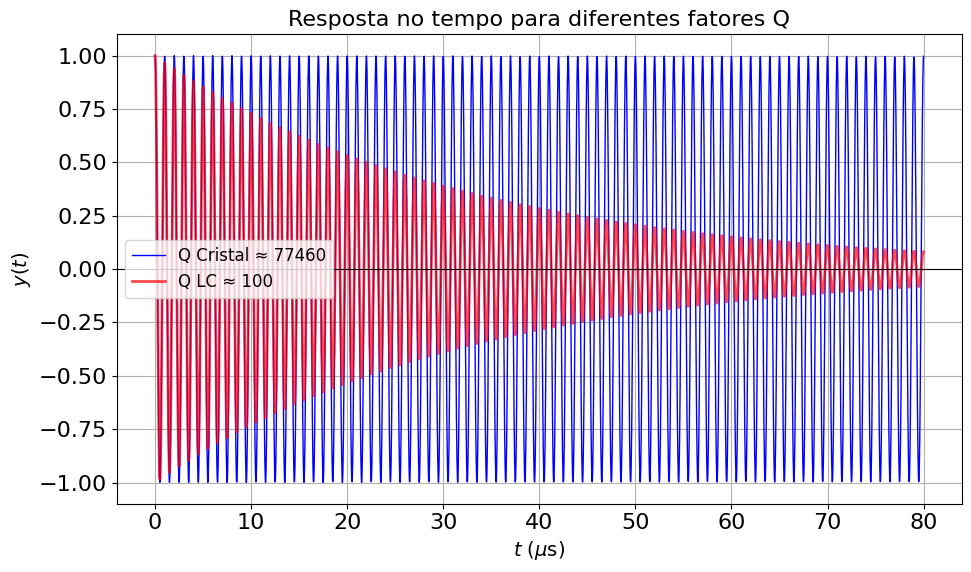

In [43]:
import numpy as np
import matplotlib.pyplot as plt

# Parâmetros de exemplo (você deve definir R1, L1, C1, fs_real conforme seu código)
R1 = 100
L1 = 1e-3
C1 = 1e-9
fs_real = 1e6  # 1 MHz, só como exemplo

# Valor de Q teórico (motional branch)
Q_static = 77460
print(f"Fator Q (teórico): {Q_static:.2f}")

# Tempo mais longo para observar amortecimento
t = np.linspace(0, 80e-6, 3000)  # 0 a 50 µs
omega = 2 * np.pi * fs_real

# Resposta com Q real
alpha_real = np.pi * fs_real / Q_static
y_real = np.exp(-alpha_real * t) * np.cos(omega * t)

# Resposta com Q = 100 (Q_artificial)
Q_artificial = 100
alpha_lowQ = np.pi * fs_real / Q_artificial
y_lowQ = np.exp(-alpha_lowQ * t) * np.cos(omega * t)

# Plot sobreposto
plt.figure(figsize=(10, 6))
plt.plot(t * 1e6, y_real, label=f'Q Cristal ≈ {Q_static:.0f}', color='blue', linewidth=1)
plt.plot(t * 1e6, y_lowQ, label=f'Q LC ≈ {Q_artificial}', color='red', linewidth=2, alpha=0.7)

plt.xlabel(r'$t$ ($\mu$s)', fontsize=14)
plt.ylabel(r'$y(t)$', fontsize=14)
plt.title('Resposta no tempo para diferentes fatores Q', fontsize=16)
plt.axhline(0, color='black', linewidth=0.8)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()
